# Finetuning Pre-trained Building Footprint Model

* 🔬 Data Science
* 🥠 Deep Learning and Instance Segmentation

## Table of Contents
* [Introduction](#Introduction)
* [Load training data](#Load-training-data)
 * [Visualize training data](#Visualize-training-data)
* [Model finetuning](#Model-finetuning)
 * [Load a pre-trained building footprint model](#Load-a-pre-trained-building-footprint-model)
 * [Test-the-model-on-our-dataset](#Test-the-model-on-our-dataset)
 * [Train the model](#Train-the-model)
 * [Visualize detected building footprints](#Visualize-detected-building-footprints)
 * [Save model](#Save-model)
* [Model inference](#Model-inference)

## Introduction

ArcGIS Living Atlas hosts a variety of [pre-trained models](https://livingatlas.arcgis.com/en/browse/?q=dlpk). While these models work well on geography that the model's training data was exported from, they may not perform well on other geographies.

However, we can improve the performance of these models on different geographies by finetuning the model on our own training data. When compared to training a similar model from scratch, this process will save time, is computationally less intensive, and will provide more accurate results.

In this workflow, we will perform three broad steps.

- Load the training data
- Finetune a pre-trained model
- Deploy the model and extract footprints



This workflow requires deep learning dependencies to be installed. Documentation is available [here](https://developers.arcgis.com/python/guide/install-and-set-up/) that outlines how to install and setup an appropriate environment.

## Load training data

In [1]:
from arcgis.gis import GIS
gis = GIS('home')
portal = GIS('https://pythonapi.playground.esri.com/portal')

In [2]:
training_data = gis.content.get('5351aca735604197ac8d8ede45f6cc4b')
training_data

<Item title:"building_footprints_kuwait_osm_sample" type:Image Collection owner:api_data_owner>

In [5]:
filepath = training_data.download(file_name=training_data.name)

In [12]:
import zipfile
from pathlib import Path
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [17]:
data_path = Path(filepath).parent / 'building_footprints'

In [6]:
from arcgis.learn import prepare_data
data = prepare_data(data_path, 
                    batch_size=16, 
                    chip_size=400)

Please check your dataset. 3 images dont have the corresponding label files.


### Visualize training data

To get a sense of what the training data looks like, use the `show_batch()` method to randomly pick a few training chips and visualize them. The chips are overlaid with masks representing the building footprints in each image chip.

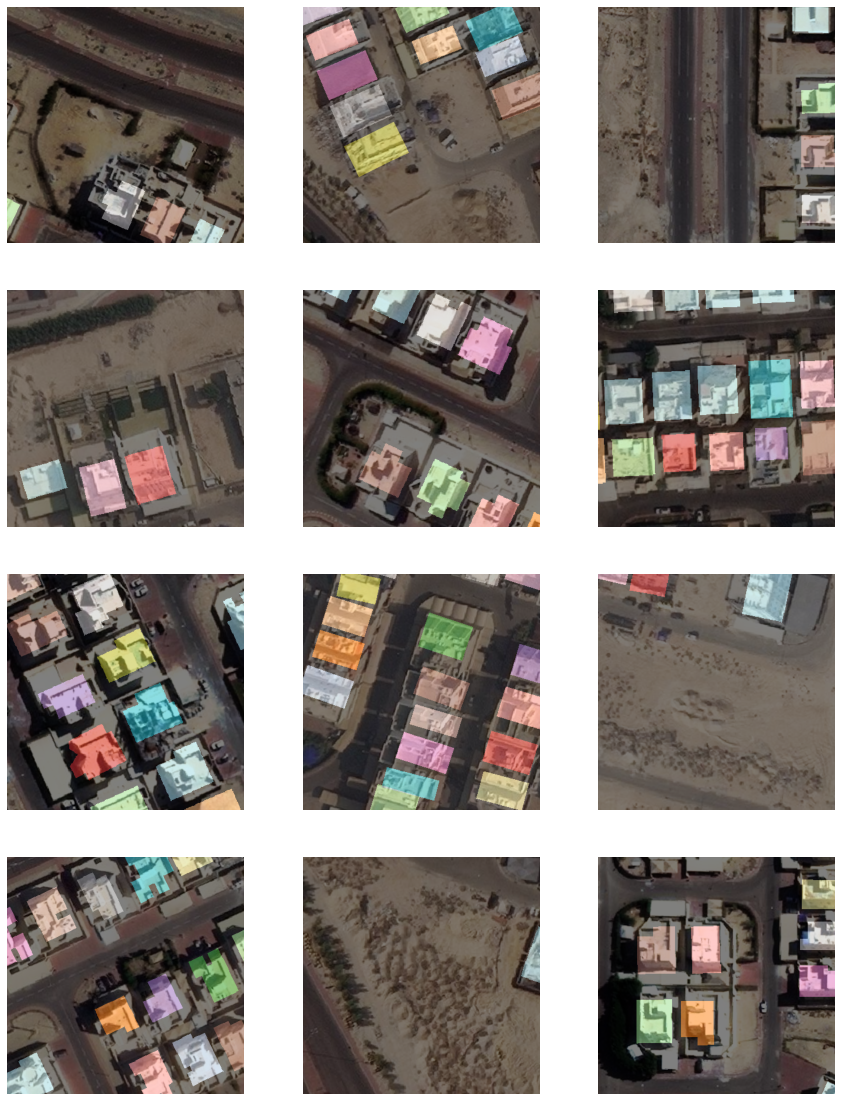

In [20]:
data.show_batch(rows=4)

## Model finetuning

### Load a pre-trained building footprint model

We can search ArcGIS Living Atlas for [Pre-trained models](https://livingatlas.arcgis.com/en/browse/?q=dlpk). 

From a model's page on living atlas, we can either directly download the model from the page or find the itemid in the URL to download it using the ArcGIS Python API as follows.

<Item title:"Building Footprint Extraction - USA" type:Deep Learning Package owner:esri_analytics>
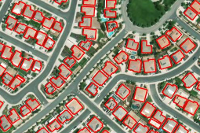

In [7]:
model_item = gis.content.get('a6857359a1cd44839781a4f113cd5934')
model_item

Next, we download the model.

In [28]:
model_path = model_item.download(file_name=model_item.name)

Once the model is downloaded, we can then load the model.

In [9]:
from arcgis.learn import MaskRCNN
model = MaskRCNN.from_model(model_path, data)

### Test the model on our dataset

In this sample, our dataset has been curated from Kuwait, which has a very different geography when compared to the data from the United States that was used to train the 'Building Footprint Extraction - USA' model.
  
We will run the {model}.`show_results()` method to check the performance of the model on our dataset, and as the model has not yet been trained on the Kuwaiti data, it is expected that the model will not perform well.

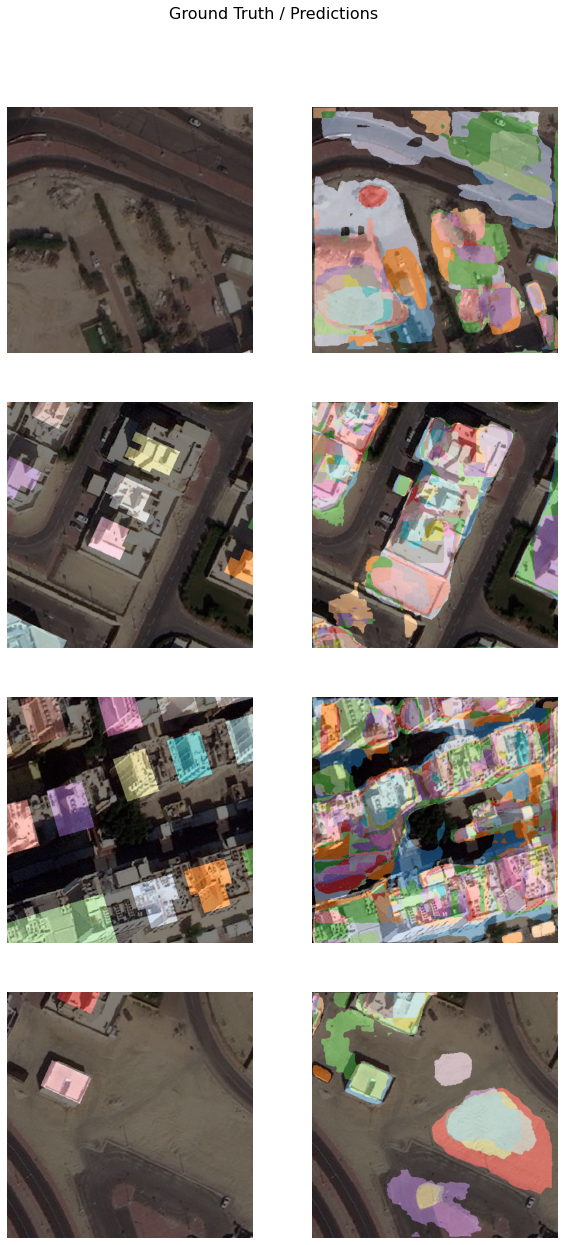

In [10]:
model.show_results()


The learning rate is one of the most important hyperparameters in training a model. We will use the `lr_find()` method to find an optimal learning rate that will allow us to fine tune the model.

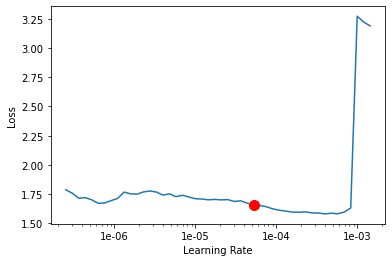

5.248074602497728e-05

In [31]:
lr = model.lr_find()
lr

### Train the model

Next, we will use the learning rate suggested above to train our model for 10 epochs.

In [11]:
model.fit(10,lr=lr)

## Visualize detected building footprints

The `model.show_results()` method can be used to display the detected building footprints. Each detection is visualized as a mask by default.

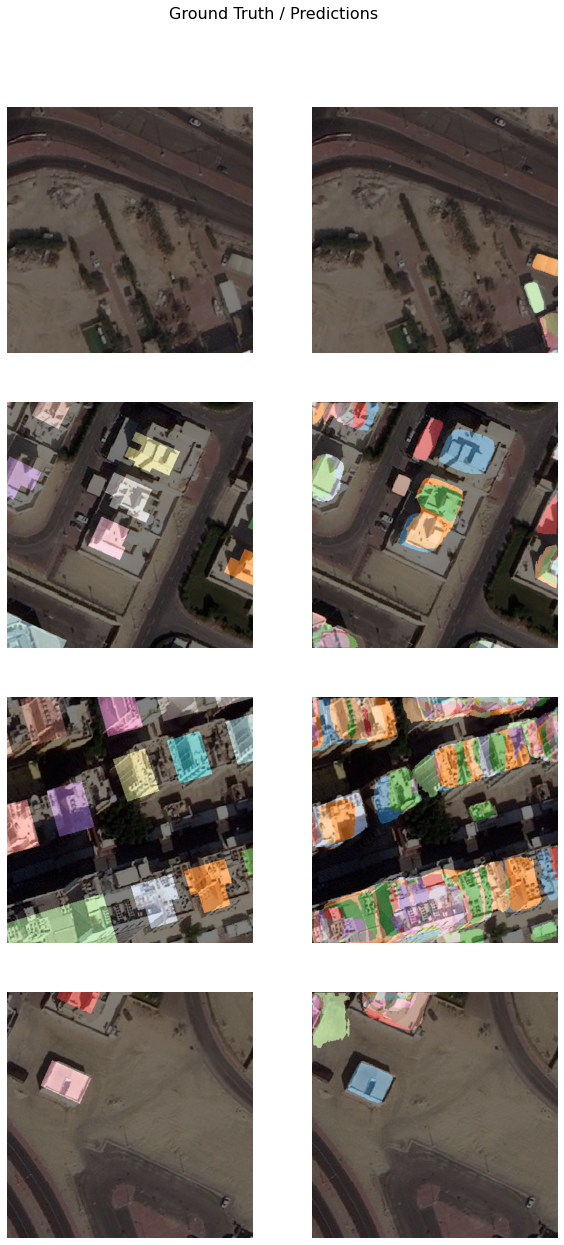

In [12]:
model.show_results()

We can set the mode parameter to `bbox_mask` to visualize both masks and bounding boxes.

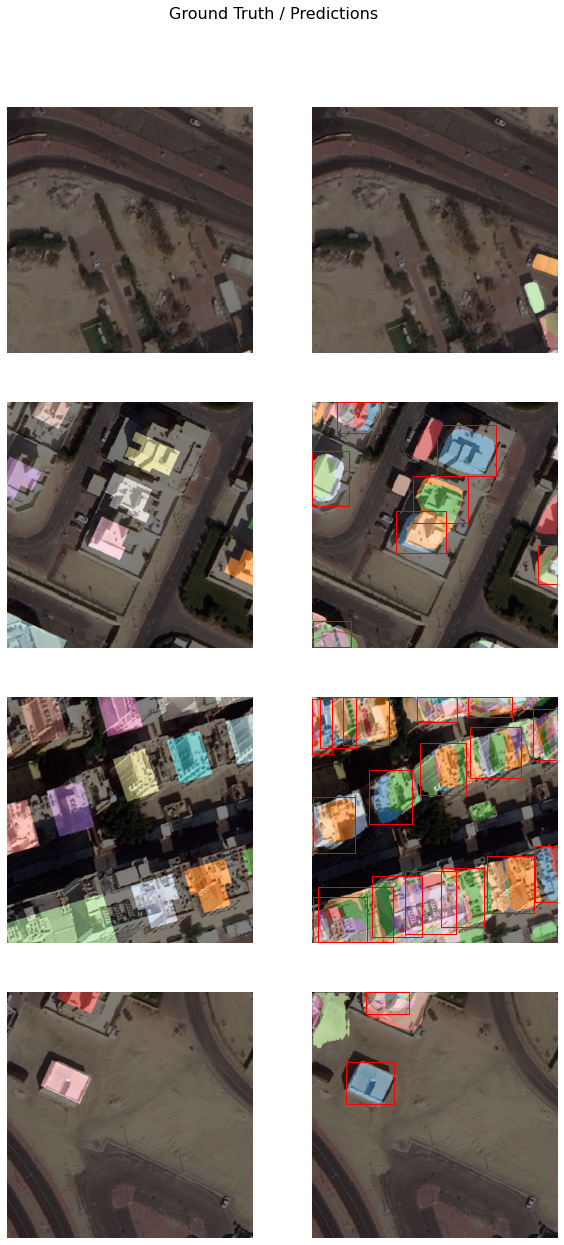

In [13]:
model.show_results(mode='bbox_mask')

### Save the model

As we can see, with 10 epochs, we are already seeing reasonable results. More improvements can be achieved by training the model further or by adding more training data. Let's save the model, so that it can be used for inference or further training. By default, it will be saved into the `path` that you specified in the very beginning of this notebook, in the `prepare_data` call.

In [ ]:
model.save('Building_footprint_10epochs')

## Model inference

The saved model can now be used to extract building footprint masks using the 'Detect Objects Using Deep Learning' tool available in ArcGIS Pro or ArcGIS Enterprise. For this sample, we will use high satellite imagery to detect footprints.

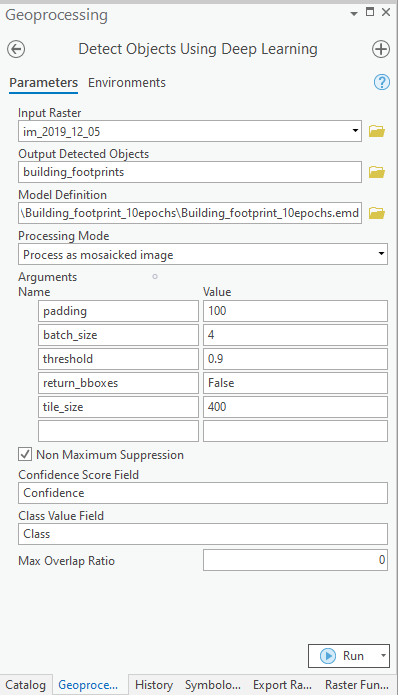

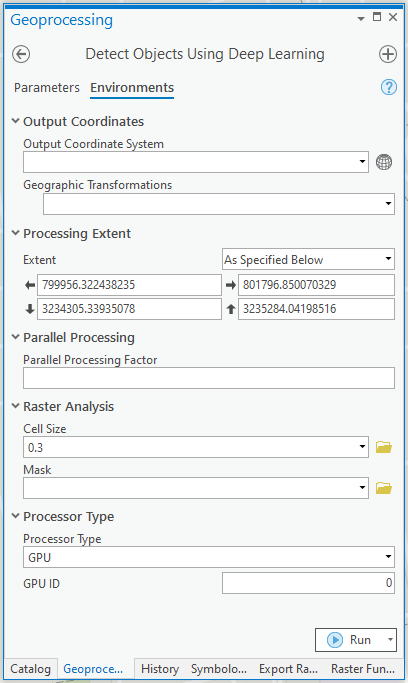

You can also achieve this using arcpy.

```python
with arcpy.EnvManager(
    extent="799956.322438235 3234305.33935078 801796.850070329 3235284.04198516", 
    cellSize=0.3, 
    processorType="GPU"
):
    arcpy.ia.DetectObjectsUsingDeepLearning(
        "im_2019_12_05", 
        r"C:\building_footprints\building_footprints.gdb\building_footprints", 
        r"C:\building_footprints\Building_footprint_10epochs\Building_footprint_10epochs.emd", 
        "padding 100;batch_size 4;threshold 0.9;return_bboxes False;tile_size 400", 
        "NMS", 
        "Confidence", 
        "Class", 
        0, 
        "PROCESS_AS_MOSAICKED_IMAGE"
    )
```

The output of the model is a layer of detected building footprints that need to be post-processed using the [Regularize Building Footprints](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/regularize-building-footprint.htm) tool. This tool normalizes the footprint of building polygons by eliminating undesirable artifacts in their geometry. The post-processed building footprints are shown below:

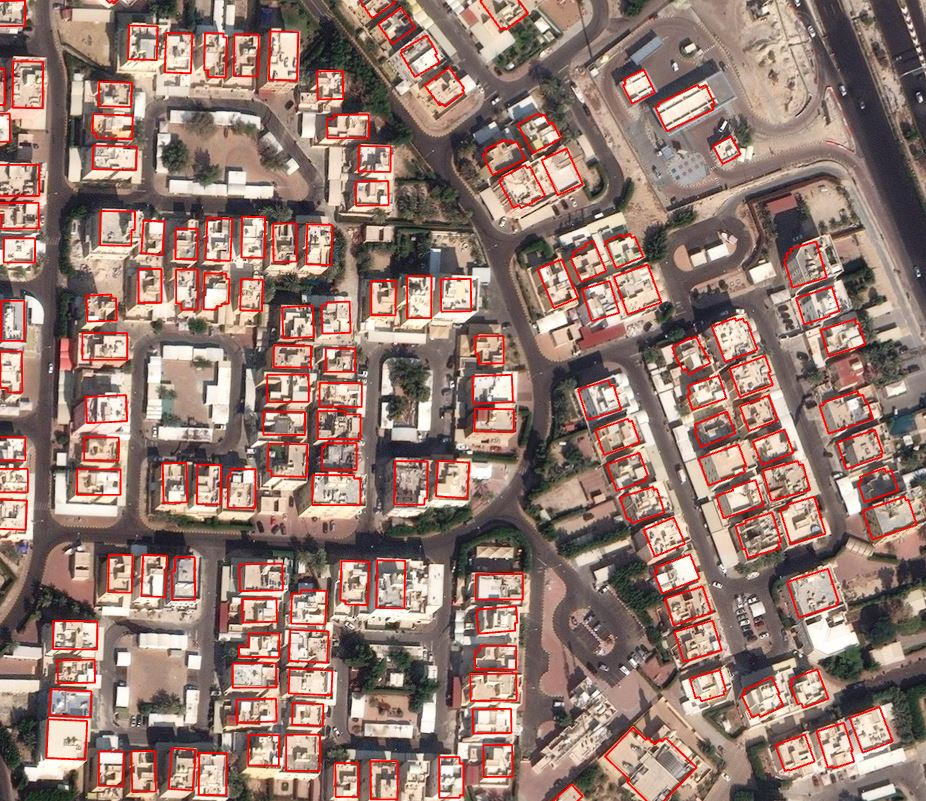

<center>A subset of detected building footprints